<a href="https://colab.research.google.com/github/OUCTheoryGroup/colab_demo/blob/master/Change_detection_PCA_KM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 基于 PCA 和 K-Means 的SAR图像变化检测

T. Celik, Unsupervised Change Detection in Satellite Images Using Principal Component Analysis and -Means Clustering, *IEEE Geoscience and Remote Sensing Letters*, 2009.

这是遥感图像变化检测领域一篇非常经典的论文，思路简单，效果较好。而且在此之前，变化检测的论文非常的少，本文作者还提供了代码，因此，这篇论文就成为经典中的经典，被广泛引用。

本文主要思路是，首先两幅图像直接做差，得到一个差分图像（Difference Image）。显而易见，在差分图像中，发生变化的区域肯定值比较大，没有发生变化的区域值就比较小。所以，是不是可以通过分析差分图像得到图像中的变化区域呢？当然是可以的。

这篇论文就是使用非常简单的思路，对差分图像进行分析，得到图像中的变化区域。具体步骤如下：
- 差分图像每个像素周围提取一个大小为 pxp 的 patch，共得到 ylen*xlen 个样本
- 对每一个样本使用 PCA 降维到 s 
- 此时，有ylen*xlen个样本，每个样本的特征维度为 s，利用 k-means 方法把样本聚为 2类，分别对应图像中变化的区域和不变的区域

下面结合代码来说明。首先，下载演示数据：

In [0]:
!wget https://raw.githubusercontent.com/summitgao/ImageGallery/master/bern_1.bmp
!wget https://raw.githubusercontent.com/summitgao/ImageGallery/master/bern_2.bmp
!wget https://raw.githubusercontent.com/summitgao/ImageGallery/master/bern_gt.bmp

Text(0.5, 1.0, 'different image')

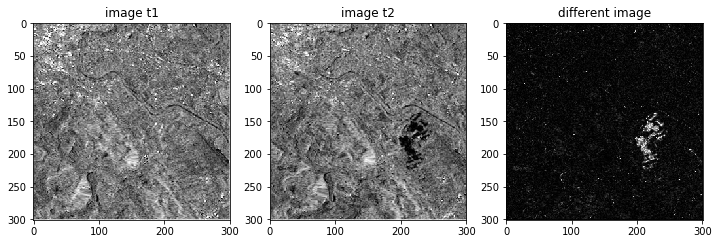

In [19]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import skimage
from skimage import data
from skimage import io

# 基本参数
# 图像分块的大小
patch_size = 5
# PCA降维后的特征维度
s = 6

# 读入图像，同时转化为 float 格式，其中im1为时相一图像，im2为时相二图像
# im_gt 为 ground truth 参考图
im1 = io.imread('bern_1.bmp')[:,:,0].astype(np.float64)
im2 = io.imread('bern_2.bmp')[:,:,0].astype(np.float64)
im_gt = io.imread('bern_gt.bmp')[:,:,0].astype(np.float64)

# 计算差分图像，因为输入的是SAR图像，这里使用的是在 SAR图像分析中应用较多的 log-ratio 算子
im_di = abs(np.log((im1+1)/(im2+1)))

# 分别画出 im1, im2, im_di
plt.figure(figsize=(12, 4))
plt.subplot(131)   
plt.imshow(im1, 'gray')   
plt.title('image t1')
# Plot image t2
plt.subplot(132)   
plt.imshow(im2, 'gray')   
plt.title('image t2')
# Plot difference image
plt.subplot(133)   
plt.imshow(im_di, 'gray')   
plt.title('different image')

上面分别展示了时相一图像、时相二图像、差分图像。可以看到，差分图像中比较亮的区域是变化区域，不变化的区域由相对较暗。

接下来，在差分图像中，每个像素周围都要取一个 5x5 的 patch 用于特征分析。这样四个边缘上的像素怎么办呢？为了能够处理四个边缘的像素，下面代码给图像做 padding 操作（即在边缘上做填充）。

因为图像块的大小为5x5，需要在四边上各填充几个像素呢？答案是2 (即填充半径pad)。左边填充2个像素，这样原差分图像中最左侧的像素周围不能够提取到 5x5 的 patch 。

因此，创建一个新矩阵 im_new ，尺寸为 [ylen+2pad]x[xlen+2pad]。然后把原来的差分图像填充到 im_new 的中心，代码如下：


In [0]:
pad = int((patch_size-1)/2)
ylen, xlen = im_di.shape
im_new = np.zeros((ylen+2*pad, xlen+2*pad), np.float64)
im_new[pad:ylen+pad, pad:xlen+pad] = im_di

下面把每个像素周围提取5x5的patch，保存在 patchData 中。这是一个三维矩阵，第一维为 ylen*xlen，即差分中图像像素的数量。然后利用两个循环把图像数据从 im_new 中取出来。

In [21]:
# 分块数据
patchData = np.zeros((ylen*xlen, patch_size, patch_size), np.float64)

idx = 0
for j in range(pad, ylen+pad):
  for i in range(pad, xlen+pad):
    patch = im_new[j-pad:j+pad+1, i-pad:i+pad+1]   
    patchData[idx, :, :] = patch
    idx=idx+1

print('patchData shape: ', patchData.shape)

patchData shape:  (90601, 5, 5)


从上面的的输出可以看到 patchData 的尺寸为(90601, 5, 5)

接下来，我们把 patchData 里面的图像块，reshape成一维向量，然后对每个一维向量进行 PCA 变换，降为6维。这里使用到了 sklearn.decomposition.PCA ，代码如下：

In [22]:
patchData = np.reshape(patchData, (ylen*xlen, patch_size*patch_size))
print('Before PCA, patchData shape: ', patchData.shape)
pca = PCA(s, whiten=True)
patchData = pca.fit_transform(patchData)
print('After  PCA, patchData shape: ', patchData.shape)

Before PCA, patchData shape:  (90601, 25)
After  PCA, patchData shape:  (90601, 6)


从上面的输出可以看到，patchData 的尺寸本来为  (90601, 25)，但经过 PCA降维，尺寸变为 (90601, 6)。

接下来，我们使用 k-means 方法对 patchData 聚为两类，结果保存在 im_res 中。

In [0]:
km = KMeans(2, 'k-means++')
km.fit(patchData)
im_res = km.labels_
im_res = np.reshape(im_res, [ylen, xlen])

下面，我们定义了一个函数来评估变化检测的准确率，常用的指标包括：PCC, OE, FA, MA 等。 FA指的是虚警，即多少不变的像素被错误的判断为变化类。 MA指的是漏警，即多少变化类的像素没检测出来，被漏掉了。OE 是FA和MA的和。

In [0]:
def evaluate(gtImg, tstImg):
#  Inputs:  gtImg  = ground truth image
#           tstImg = change map
#  Outputs: FA  = False alarms
#           MA  = Missed alarms
#           OE  = Overall error
#           PCC = Overall accuracy
  gtImg[np.where(gtImg>128)] = 255
  gtImg[np.where(gtImg<128)] = 0
  tstImg[np.where(tstImg>128)] = 255
  tstImg[np.where(tstImg<128)] = 0
  [ylen, xlen] = gtImg.shape
  FA = 0
  MA = 0

  for j in range(0,ylen):
    for i in range(0,xlen):
      if gtImg[j,i]==0 and tstImg[j,i]!=0 :
        FA = FA+1
      if gtImg[j,i]!=0 and tstImg[j,i]==0 :
        MA = MA+1
  
  OE = FA+MA
  PCC = 1-OE/(ylen*xlen)
  print(' Change detection results ==>')
  print(' ... ... FA:  ', FA)
  print(' ... ... MA:  ', MA)
  print(' ... ... OE:  ', OE)
  print(' ... ... PCC: ', format(PCC*100, '.2f'))

最后，我们把计算得到的 im_res 和标准的 ground truth 进行比较，评价算法的准确率。这里需要考虑一个因素，即 k-means 算法聚类会给每个样本一个标签（0或者1），但因为没有先验信息，我们并不知道这个标签对应的到底是变化类还是不变类。

那么问题就来了，我们如何判断哪个是变化类，哪个是不变类呢？

大家肯定容易想到，差分图像中，经较亮的区域是变化类，比较暗的区域是不变类。因此，我们在差分图像中把两类像素分别找出来，计算其均值。均值较小的一类是不变类，均值较大的一类是变化类。

最后，我们调用 evaluate 函数，评价变化检测结果的准确率。

 Change detection results ==>
 ... ... FA:   223
 ... ... MA:   119
 ... ... OE:   342
 ... ... PCC:  99.62


Text(0.5, 1.0, 'Ground truth image')

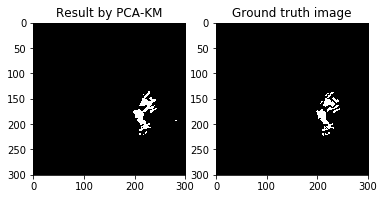

In [25]:
# 分别找到 im_res 中label为0和1的像素的位置，保存在 idx1 和 idx2 中
idx1 = np.where(im_res==0)
idx2 = np.where(im_res==1)
# 计算这些像素在差分图像中的均值，然后分别在 im_res 中重新赋值
# 变化类赋值 255，不变类赋值 0
if im_di[idx1].mean() > im_di[idx2].mean() :
  im_res[idx1] = 255
  im_res[idx2] = 0
else :
  im_res[idx1] = 0
  im_res[idx2] = 255

evaluate(im_gt, im_res)

plt.subplot(121)   
plt.imshow(im_res, 'gray')   
plt.title('Result by PCA-KM')
plt.subplot(122)
plt.imshow(im_gt, 'gray')   
plt.title('Ground truth image')

上图中左侧是 PCA-KM 方法的变化检测结果，右边是 ground truth 参考图，可以看二，准确率还是相当高的。从客观指标上来看，准确率为 99.61%，也是相当令人满意的。

PCA-KM 算法因为在差分图像的每个像素周围提取一个 patch 进而分析特征，考虑了像素的领域信息，因此得到的虚警较少，得到的变化检测结果中几乎没有噪声。